In [4]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('Report_21_050718_3.xls')

In [3]:
df_demographics = pd.read_excel('Proteomics-Subjects_Wcodes.xlsx')

In [5]:
df.columns = df.columns.str.replace(' ','_').str.lower()
df_demographics.columns = df_demographics.columns.str.replace(' ','_').str.lower()

In [6]:
'''
Converting long data to wide data
There are 12 subjects per group with 2 different dosages and total of 3 groups for 72 rows. 
We first identify the 72 columns, iterate through them and create one row per that item using pivot.
'''
out = pd.DataFrame()
for i in list(df.columns[((df.columns.str.endswith('_1') | df.columns.str.endswith('_2')))]):
    pat_info = i.split('_')
    df['pat_id'] = pat_info[0][1:]
    row = df.pivot(index='pat_id', columns='uniprot_id', values=i)
    row['dt_start'] = pat_info[1]
    row['dt_end'] = pat_info[2]
    row['dose']  = pat_info[3][:-2]
    row['group']  = pat_info[0][0]
    out = out.append(row)

In [7]:
out.index = out.index.astype('int64')
df_demographics.set_index('id',inplace=True)
out = out.join(df_demographics)

In [8]:
out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 113 to 1043
Columns: 1139 entries, 1433B_HUMAN to suicide
dtypes: float64(1131), int64(1), object(7)
memory usage: 641.2+ KB


In [9]:
out.suicide.value_counts()

Suicide     38
Non-Suic    34
Name: suicide, dtype: int64

In [71]:
out.head()

,1433B_HUMAN,1433E_HUMAN,1433F_HUMAN,1433G_HUMAN,1433S_HUMAN,1433T_HUMAN,1433Z_HUMAN,2AAA_HUMAN,2ABA_HUMAN,2ABD_HUMAN,...,ZN346_HUMAN,ZNF76_HUMAN,dt_start,dt_end,dose,group,age,sex,gr,suicide
113,810919.625,1834369.625,1392117.625,1956605.875,70254.930,474045.375,6620744.0,1291516.250,461692.156,529325.312,...,58731.387,36183.840,080515,082115,2,c,66,Male,C,Non-Suic
113,979915.312,1824592.875,1120456.625,2091506.750,89526.766,511258.094,7785243.5,1354807.375,520214.781,589599.125,...,75773.492,39117.086,080515,083115,4,c,66,Male,C,Non-Suic
118,914548.438,1854424.500,959073.062,1457951.625,93304.797,457482.219,7300623.5,1291576.500,398318.875,527421.375,...,89240.133,30450.059,080515,090215,5,a,31,Female,MDD*SSRI,Suicide
118,907351.750,1838558.750,1072144.375,1534899.750,86471.102,514485.250,6757149.0,1213667.875,404712.719,444648.688,...,87685.891,37354.352,080515,091515,5,a,31,Female,MDD*SSRI,Suicide
178,642208.750,1573063.250,948511.250,1410201.750,33571.168,406018.250,5112435.0,976768.875,343902.938,480558.625,...,62084.770,37259.727,080515,082115,2,c,25,Male,C,Non-Suic


In [112]:
data = out

# Visualize gender impact on suicide

We see that gender does not have an impact here. As in, the data has equal number of males and females in both categories.

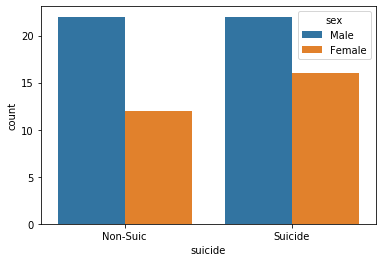

In [22]:
ax = sns.countplot(x="suicide", hue="sex", data=data)

In [113]:
data = data.drop(['group','gr','dt_start','dt_end','dose'], axis=1)

In [114]:
data = pd.get_dummies(data, columns=['sex'])

In [115]:
data['suicide'] = data.suicide.replace(to_replace=['Non-Suic', 'Suicide'], value=[0, 1])
data_y = data['suicide']
data_x = data.drop('suicide', axis = 1)

# Use random forest to identify important features

In [55]:
import warnings
from sklearn.ensemble import RandomForestClassifier

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    forest = RandomForestClassifier(n_estimators=50,class_weight="balanced")
    forest.fit(data_x,data_y)

In [56]:
importances = forest.feature_importances_

In [57]:
indices = np.argsort(importances)[::-1]

df_list = []

for f in range(data_x.shape[1]):
    df_list.append([list(data_x.columns)[indices[f]], importances[indices[f]]])
    
feature_rank = pd.DataFrame(df_list)
feature_rank = feature_rank.rename(columns={0:'feature',1:'importance'})

In [58]:
feature_rank[feature_rank['feature']=='sex_Female']

,feature,importance
954,sex_Female,0.0


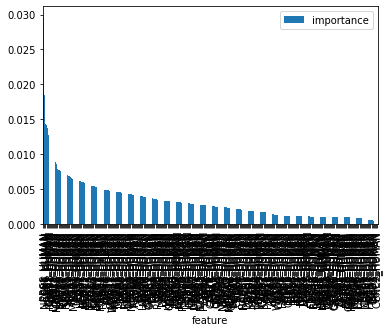

In [32]:
feature_rank[feature_rank['importance']>0].plot.bar(x='feature', y='importance', rot=90)

There are totally around 307 features that have non zero importance.

# Visualize the distribution of the most important feature identified by Random Forest

PHLB3_HUMAN


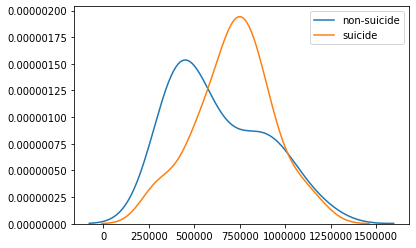

In [59]:
feature1 = feature_rank.iloc[0]['feature']
print(feature1)
sns.kdeplot(data[(data['suicide']==0)][feature1],label='non-suicide')
sns.kdeplot(data[(data['suicide']==1)][feature1],label='suicide')

# Run t-test to see which features are statistically significant between two groups

In [127]:
from scipy import stats

pvalues = []
for index,row in feature_rank[feature_rank['importance']>0].iterrows():
    feature = row['feature']
    if feature != 'dt_end':
        p = stats.ttest_ind(data[data['suicide']==0][feature],data[data['suicide']==1][feature])[1]
        
        pvalues.append([feature,p])

pvalues = pd.DataFrame(pvalues)
pvalues = pvalues.rename(columns={0:'feature',1:'pvalues'})
pvalues

,feature,pvalues
0,FGF9_HUMAN,0.008832
1,SBDS_HUMAN,0.014280
2,KAD3_HUMAN,0.023327
3,PGRC1_HUMAN,0.107680
4,NDUAB_HUMAN,0.935491
...,...,...
301,PGAM1_HUMAN,0.074613
302,DIRA2_HUMAN,0.249031
303,PPM1L_HUMAN,0.778005
304,GMFB_HUMAN,0.309541


In [128]:
pvalues[pvalues['pvalues']<0.05]

,feature,pvalues
0,FGF9_HUMAN,0.008832
1,SBDS_HUMAN,0.014280
2,KAD3_HUMAN,0.023327
5,SYFA_HUMAN,0.000068
6,PSA7_HUMAN,0.041253
7,ZNF76_HUMAN,0.014285
8,PRS8_HUMAN,0.002483
10,CPNE1_HUMAN,0.001116
13,NCKP1_HUMAN,0.043113
14,CDK13_HUMAN,0.007710


At a 0.05 significance level, there are 272 features that are statistically significant between the two groups.

# Conduct non-parametric wilcoxon test

In [43]:
from scipy import stats

pvalues = []
for index,row in feature_rank[feature_rank['importance']>0].iterrows():
    feature = row['feature']
    if feature != 'dt_end':
        p = stats.wilcoxon(data[data['suicide']==0][feature],data[data['suicide']==1][feature].sample(n=34))[1]
        
        pvalues.append([feature,p])

pvalues = pd.DataFrame(pvalues)
pvalues = pvalues.rename(columns={0:'feature',1:'pvalues'})
pvalues

,feature,pvalues
0,PRS8_HUMAN,0.000781
1,NECP1_HUMAN,0.011678
2,PYC_HUMAN,0.130269
3,CSN4_HUMAN,0.046399
4,HINT2_HUMAN,0.082688
...,...,...
301,EHD3_HUMAN,0.638245
302,CRIP2_HUMAN,0.817468
303,ACTS_HUMAN,0.063600
304,RFC5_HUMAN,0.566825


In [44]:
pvalues[pvalues['pvalues']<0.05]

,feature,pvalues
0,PRS8_HUMAN,0.000781
1,NECP1_HUMAN,0.011678
3,CSN4_HUMAN,0.046399
5,GNAI2_HUMAN,0.042771
6,NCKP1_HUMAN,0.023495
7,TBA4B_HUMAN,0.026829
8,SYFA_HUMAN,0.000133
10,GBF1_HUMAN,0.011122
12,MBOA7_HUMAN,0.004918
13,CN166_HUMAN,0.010590


There are 287 significant features as opposed to 272 features from the previous t-test.

In [116]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

data_cat = data_x[['sex_Male','sex_Female']]
data_x = data_x.drop(['sex_Male','sex_Female'], axis=1)
scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)
data_cat = np.array(data_cat)
data_x = np.append(data_x, data_cat, 1)


In [128]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(data_x)
kmeans.labels_

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1])

In [123]:
cluster = kmeans.labels_
truth = list(data_y)
pd.DataFrame(data={'cluster':cluster,'truth':truth})

,cluster,truth
0,0,0
1,1,0
2,0,1
3,0,1
4,0,0
...,...,...
67,1,0
68,0,1
69,0,1
70,0,0


In [124]:
c1,c2,c3 = 0,0,0
for i in range(0,len(cluster)):
    if (cluster[i] == 0) & (truth[i]==1):
        c1 = c1+1
    elif (cluster[i]==1) & (truth[i]==0):
        c2 = c2+1
    else:
        c3 = c3+1
    

In [125]:
print(c1)
print(c2)
print(c3)

29
15
28
